In [ ]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

from src.data.data import *
from src.GP.plotting import *

/Users/jfawkes/Documents/Obs_and_exp_data/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
kallus_func = lambda X,U,T,eps: 1+T+X+2*T*X+0.5*X**2+0.75*T*X**2+2*U*X+0.5*eps


cfoundeded_func = lambda X,T: 1+T+X+2*T*X+0.5*X**2+0.75*T*X**2+2*(T-0.5)*X**2
uncfounded_func = lambda X,T: 1+T+X+2*T*X+0.5*X**2+0.75*T*X**2

kallus_outcome_funcs = outcome_funcs(cfounded_func=cfoundeded_func,
              uncfounded_func=uncfounded_func)

T_prop = 0.5
n_samples_exp = 200
n_samples_obs = 1000

In [3]:
exp_data,obs_data,outcome_funcs_GP = get_train_data_GP_1d(kallus_outcome_funcs,
                         n_samples_exp = n_samples_exp,n_samples_obs = n_samples_obs, 
                         exp_range = (-1,1),obs_range = (-3,3),
                         T_prop = T_prop,train_data = None)

(<Figure size 1600x400 with 3 Axes>,
 array([<Axes: title={'center': 'Observational Data'}, xlabel='X', ylabel='Y'>,
        <Axes: title={'center': 'Experimental Data'}, xlabel='X'>,
        <Axes: title={'center': 'Pseudo Outcomes'}, xlabel='X'>],
       dtype=object))

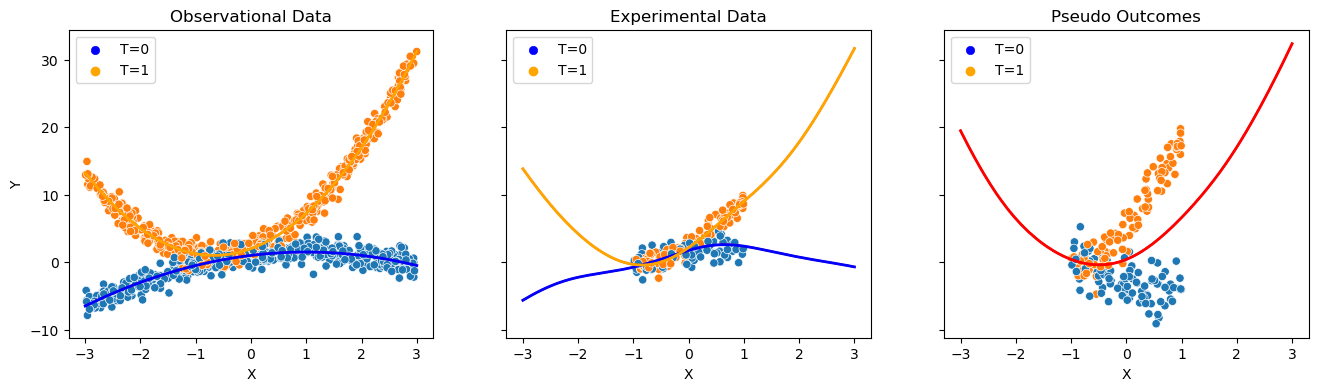

In [4]:
obs_exp_pseudo_plot(obs_data,exp_data,outcome_funcs_GP,T_prop=T_prop)

In [5]:
exp_data_adjusted = adjust_data(exp_data,kallus_outcome_funcs.cfounded_func)
pseudo_adjust_data = get_pseudo_outcome_data(exp_data_adjusted,T_prop=T_prop)

train_x0 = get_conditioned_data(pseudo_adjust_data,T_val=0).X
train_x1 = get_conditioned_data(pseudo_adjust_data,T_val=1).X

train_y0 = get_conditioned_data(pseudo_adjust_data,T_val=0).Y
train_y1 = get_conditioned_data(pseudo_adjust_data,T_val=1).Y

train_x0 = get_conditioned_data(pseudo_adjust_data,T_val=0).X
train_x1 = get_conditioned_data(pseudo_adjust_data,T_val=1).X

train_y0 = get_conditioned_data(pseudo_adjust_data,T_val=0).Y
train_y1 = get_conditioned_data(pseudo_adjust_data,T_val=1).Y

In [6]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

        # We learn an IndexKernel for 2 tasks
        # (so we'll actually learn 2x2=4 tasks with correlations)
        self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=2, rank=1)

    def forward(self,x,i):
        mean_x = self.mean_module(x)

        # Get input-input covariance
        covar_x = self.covar_module(x)
        # Get task-task covariance
        covar_i = self.task_covar_module(i)
        # Multiply the two together to get the covariance we want
        covar = covar_x.mul(covar_i)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar)
    
    def CATE(self,x):

        n = x.shape[0]

        zeros_like_x = torch.full((x.shape[0],1), dtype=torch.long, fill_value=0)
        ones_like_x = torch.full((x.shape[0],1), dtype=torch.long, fill_value=1)

        out = self(torch.cat([x, x]),torch.cat([ones_like_x, zeros_like_x]))
        
        mean = out.mean.detach()[:n] - out.mean.detach()[n:]
        
        covar = out.lazy_covariance_matrix
        stdv = covar[:n,:n].diag()+covar[n:,n:].diag() - 2*covar[n:,:n].diag() 
        return mean, stdv 

likelihood = gpytorch.likelihoods.GaussianLikelihood()

train_i_task1 = torch.full((train_x0.shape[0],1), dtype=torch.long, fill_value=0)
train_i_task2 = torch.full((train_x1.shape[0],1), dtype=torch.long, fill_value=1)

full_train_x = torch.cat([train_x0, train_x1])
full_train_i = torch.cat([train_i_task1, train_i_task2])
full_train_y = torch.cat([train_y0, train_y1])

# Here we have two iterms that we're passing in as train_inputs
model = MultitaskGPModel((full_train_x, full_train_i), full_train_y, likelihood)

In [7]:
# this is for running the notebook in our testing framework
import os

smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(full_train_x, full_train_i)
    loss = -mll(output, full_train_y)
    loss.backward()
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 3.618
Iter 2/50 - Loss: 3.452
Iter 3/50 - Loss: 3.305
Iter 4/50 - Loss: 3.175
Iter 5/50 - Loss: 3.060
Iter 6/50 - Loss: 2.959
Iter 7/50 - Loss: 2.869
Iter 8/50 - Loss: 2.790
Iter 9/50 - Loss: 2.720
Iter 10/50 - Loss: 2.658
Iter 11/50 - Loss: 2.602
Iter 12/50 - Loss: 2.551
Iter 13/50 - Loss: 2.506
Iter 14/50 - Loss: 2.466
Iter 15/50 - Loss: 2.431
Iter 16/50 - Loss: 2.399
Iter 17/50 - Loss: 2.372
Iter 18/50 - Loss: 2.348
Iter 19/50 - Loss: 2.328
Iter 20/50 - Loss: 2.310
Iter 21/50 - Loss: 2.295
Iter 22/50 - Loss: 2.282
Iter 23/50 - Loss: 2.270
Iter 24/50 - Loss: 2.259
Iter 25/50 - Loss: 2.249
Iter 26/50 - Loss: 2.240
Iter 27/50 - Loss: 2.232
Iter 28/50 - Loss: 2.225
Iter 29/50 - Loss: 2.218
Iter 30/50 - Loss: 2.211
Iter 31/50 - Loss: 2.206
Iter 32/50 - Loss: 2.200
Iter 33/50 - Loss: 2.196
Iter 34/50 - Loss: 2.191
Iter 35/50 - Loss: 2.187
Iter 36/50 - Loss: 2.184
Iter 37/50 - Loss: 2.180
Iter 38/50 - Loss: 2.177
Iter 39/50 - Loss: 2.174
Iter 40/50 - Loss: 2.172
Iter 41/5

/Users/jfawkes/Documents/Obs_and_exp_data/.conda/lib/python3.11/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1720538194616/work/torch/csrc/utils/tensor_new.cpp:643.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


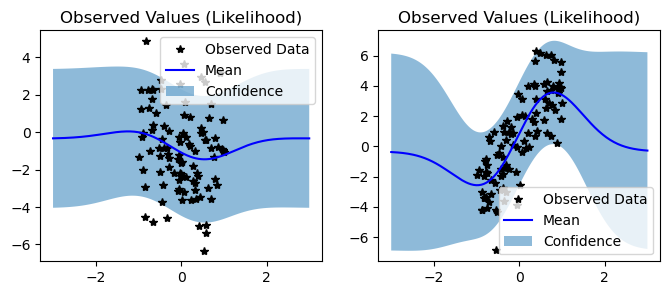

In [8]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Test points every 0.02 in [0,1]
test_x = torch.linspace(-3, 3, 200)
test_i_task0 = torch.full((test_x.shape[0],1), dtype=torch.long, fill_value=0)
test_i_task1 = torch.full((test_x.shape[0],1), dtype=torch.long, fill_value=1)

# Make predictions - one task at a time
# We control the task we cae about using the indices

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred_y0 = likelihood(model(test_x, test_i_task0))
    observed_pred_y1 = likelihood(model(test_x, test_i_task1))

# Define plotting function
def ax_plot(ax, train_y, train_x, rand_var, title):
    # Get lower and upper confidence bounds
    lower, upper = rand_var.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.detach().numpy(), train_y.detach().numpy(), 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.detach().numpy(), rand_var.mean.detach().numpy(), 'b')
    # Shade in confidence
    ax.fill_between(test_x.detach().numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
    # ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

# Plot both tasks
ax_plot(y1_ax, train_y0, train_x0, observed_pred_y0, 'Observed Values (Likelihood)')
ax_plot(y2_ax, train_y1, train_x1, observed_pred_y1, 'Observed Values (Likelihood)')

In [9]:
model(test_x, test_i_task1).mean.detach()

tensor([-0.3757, -0.3803, -0.3853, -0.3909, -0.3970, -0.4038, -0.4112, -0.4193,
        -0.4281, -0.4378, -0.4483, -0.4597, -0.4720, -0.4854, -0.4999, -0.5154,
        -0.5322, -0.5502, -0.5695, -0.5902, -0.6123, -0.6358, -0.6608, -0.6874,
        -0.7156, -0.7454, -0.7769, -0.8101, -0.8450, -0.8816, -0.9199, -0.9600,
        -1.0018, -1.0453, -1.0905, -1.1373, -1.1857, -1.2355, -1.2868, -1.3395,
        -1.3934, -1.4484, -1.5044, -1.5612, -1.6187, -1.6767, -1.7350, -1.7934,
        -1.8517, -1.9097, -1.9670, -2.0235, -2.0788, -2.1328, -2.1850, -2.2352,
        -2.2831, -2.3284, -2.3707, -2.4097, -2.4451, -2.4766, -2.5039, -2.5266,
        -2.5444, -2.5570, -2.5642, -2.5656, -2.5610, -2.5501, -2.5328, -2.5087,
        -2.4778, -2.4399, -2.3947, -2.3423, -2.2826, -2.2155, -2.1410, -2.0592,
        -1.9700, -1.8737, -1.7704, -1.6601, -1.5432, -1.4198, -1.2903, -1.1549,
        -1.0141, -0.8681, -0.7175, -0.5626, -0.4039, -0.2419, -0.0771,  0.0899,
         0.2587,  0.4285,  0.5990,  0.76

In [10]:
model.CATE(test_x)

(tensor([-0.0488, -0.0549, -0.0615, -0.0688, -0.0768, -0.0857, -0.0953, -0.1058,
         -0.1173, -0.1297, -0.1433, -0.1580, -0.1738, -0.1910, -0.2095, -0.2293,
         -0.2507, -0.2735, -0.2980, -0.3241, -0.3520, -0.3816, -0.4130, -0.4463,
         -0.4816, -0.5188, -0.5579, -0.5991, -0.6423, -0.6875, -0.7347, -0.7840,
         -0.8352, -0.8884, -0.9434, -1.0003, -1.0589, -1.1191, -1.1809, -1.2441,
         -1.3085, -1.3740, -1.4405, -1.5076, -1.5753, -1.6432, -1.7111, -1.7788,
         -1.8459, -1.9123, -1.9774, -2.0411, -2.1029, -2.1626, -2.2197, -2.2740,
         -2.3249, -2.3721, -2.4153, -2.4540, -2.4878, -2.5164, -2.5394, -2.5563,
         -2.5669, -2.5708, -2.5676, -2.5571, -2.5389, -2.5128, -2.4785, -2.4358,
         -2.3846, -2.3246, -2.2558, -2.1781, -2.0914, -1.9957, -1.8911, -1.7777,
         -1.6556, -1.5250, -1.3861, -1.2391, -1.0844, -0.9223, -0.7533, -0.5777,
         -0.3960, -0.2087, -0.0165,  0.1802,  0.3807,  0.5844,  0.7907,  0.9987,
          1.2079,  1.4175,  

In [11]:
model(test_x, test_i_task1).mean.detach() - model(test_x, test_i_task0).mean.detach()

tensor([-0.0488, -0.0549, -0.0615, -0.0688, -0.0768, -0.0857, -0.0953, -0.1058,
        -0.1173, -0.1297, -0.1433, -0.1580, -0.1738, -0.1910, -0.2095, -0.2293,
        -0.2507, -0.2736, -0.2980, -0.3241, -0.3520, -0.3816, -0.4130, -0.4463,
        -0.4816, -0.5188, -0.5579, -0.5991, -0.6423, -0.6875, -0.7347, -0.7840,
        -0.8352, -0.8884, -0.9434, -1.0003, -1.0589, -1.1191, -1.1809, -1.2441,
        -1.3085, -1.3740, -1.4405, -1.5076, -1.5753, -1.6432, -1.7111, -1.7788,
        -1.8459, -1.9123, -1.9774, -2.0411, -2.1029, -2.1626, -2.2197, -2.2740,
        -2.3249, -2.3721, -2.4153, -2.4540, -2.4878, -2.5164, -2.5394, -2.5563,
        -2.5669, -2.5708, -2.5676, -2.5571, -2.5389, -2.5128, -2.4785, -2.4358,
        -2.3846, -2.3246, -2.2558, -2.1781, -2.0914, -1.9957, -1.8911, -1.7777,
        -1.6556, -1.5250, -1.3861, -1.2391, -1.0844, -0.9223, -0.7533, -0.5777,
        -0.3960, -0.2087, -0.0165,  0.1802,  0.3807,  0.5844,  0.7907,  0.9987,
         1.2079,  1.4175,  1.6269,  1.83

In [12]:
model((test_x, test_i_task1),(test_x, test_i_task1)).covariance_matrix

AttributeError: 'tuple' object has no attribute 'ndimension'

tensor([-3.0000, -2.9698, -2.9397, -2.9095, -2.8794, -2.8492, -2.8191, -2.7889,
        -2.7588, -2.7286, -2.6985, -2.6683, -2.6382, -2.6080, -2.5779, -2.5477,
        -2.5176, -2.4874, -2.4573, -2.4271, -2.3970, -2.3668, -2.3367, -2.3065,
        -2.2764, -2.2462, -2.2161, -2.1859, -2.1558, -2.1256, -2.0955, -2.0653,
        -2.0352, -2.0050, -1.9749, -1.9447, -1.9146, -1.8844, -1.8543, -1.8241,
        -1.7940, -1.7638, -1.7337, -1.7035, -1.6734, -1.6432, -1.6131, -1.5829,
        -1.5528, -1.5226, -1.4925, -1.4623, -1.4322, -1.4020, -1.3719, -1.3417,
        -1.3116, -1.2814, -1.2513, -1.2211, -1.1910, -1.1608, -1.1307, -1.1005,
        -1.0704, -1.0402, -1.0101, -0.9799, -0.9497, -0.9196, -0.8894, -0.8593,
        -0.8291, -0.7990, -0.7688, -0.7387, -0.7085, -0.6784, -0.6482, -0.6181,
        -0.5879, -0.5578, -0.5276, -0.4975, -0.4673, -0.4372, -0.4070, -0.3769,
        -0.3467, -0.3166, -0.2864, -0.2563, -0.2261, -0.1960, -0.1658, -0.1357,
        -0.1055, -0.0754, -0.0452, -0.01

200

tensor([-9.8050e-06, -1.3351e-05, -1.8090e-05, -2.4408e-05, -3.2783e-05,
        -4.3720e-05, -5.8115e-05, -7.6771e-05, -1.0091e-04, -1.3199e-04,
        -1.7169e-04, -2.2215e-04, -2.8589e-04, -3.6600e-04, -4.6605e-04,
        -5.9023e-04, -7.4339e-04, -9.3120e-04, -1.1600e-03, -1.4369e-03,
        -1.7698e-03, -2.1673e-03, -2.6388e-03, -3.1938e-03, -3.8422e-03,
        -4.5941e-03, -5.4587e-03, -6.4446e-03, -7.5586e-03, -8.8052e-03,
        -1.0186e-02, -1.1697e-02, -1.3331e-02, -1.5073e-02, -1.6901e-02,
        -1.8781e-02, -2.0673e-02, -2.2520e-02, -2.4255e-02, -2.5796e-02,
        -2.7044e-02, -2.7885e-02, -2.8188e-02, -2.7807e-02, -2.6579e-02,
        -2.4328e-02, -2.0867e-02, -1.5996e-02, -9.5147e-03, -1.2189e-03,
         9.0920e-03,  2.1608e-02,  3.6501e-02,  5.3922e-02,  7.3989e-02,
         9.6785e-02,  1.2234e-01,  1.5064e-01,  1.8160e-01,  2.1509e-01,
         2.5088e-01,  2.8869e-01,  3.2817e-01,  3.6886e-01,  4.1026e-01,
         4.5179e-01,  4.9282e-01,  5.3263e-01,  5.7

tensor([0.8982, 0.8982, 0.8982, 0.8982, 0.8982, 0.8982, 0.8982, 0.8982, 0.8982,
        0.8982, 0.8982, 0.8982, 0.8982, 0.8982, 0.8982, 0.8982, 0.8982, 0.8982,
        0.8982, 0.8982, 0.8982, 0.8981, 0.8981, 0.8981, 0.8980, 0.8980, 0.8979,
        0.8977, 0.8975, 0.8973, 0.8969, 0.8964, 0.8958, 0.8949, 0.8938, 0.8923,
        0.8904, 0.8881, 0.8851, 0.8814, 0.8768, 0.8712, 0.8644, 0.8564, 0.8468,
        0.8356, 0.8226, 0.8077, 0.7908, 0.7717, 0.7506, 0.7273, 0.7020, 0.6747,
        0.6457, 0.6151, 0.5832, 0.5505, 0.5172, 0.4837, 0.4504, 0.4178, 0.3862,
        0.3560, 0.3275, 0.3011, 0.2769, 0.2551, 0.2358, 0.2190, 0.2046, 0.1926,
        0.1827, 0.1749, 0.1687, 0.1641, 0.1607, 0.1583, 0.1565, 0.1553, 0.1543,
        0.1535, 0.1526, 0.1518, 0.1508, 0.1497, 0.1486, 0.1475, 0.1465, 0.1458,
        0.1454, 0.1454, 0.1461, 0.1473, 0.1492, 0.1517, 0.1548, 0.1584, 0.1625,
        0.1667, 0.1710, 0.1752, 0.1791, 0.1824, 0.1849, 0.1867, 0.1874, 0.1871,
        0.1858, 0.1834, 0.1801, 0.1760, 

In [ ]:
with gpytorch.settings.fast_pred_var():
    out = model((torch.cat[X1, X2], dim=-2))
    cross_covar = out.lazy_covariance_matrix[:n, n:]

In [ ]:
model(torch.concat([test_x[:1],test_x[:1]]), torch.concat([test_i_task0[:1],test_i_task1[:1]])).ker.detach()


tensor([[0.4443, 0.2579],
        [0.2579, 0.3987]])